In [4]:
# Importing required libraries
import nltk
import pandas as pd
from nltk.corpus import stopwords
from textblob import Word
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import wordcloud
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np


In [7]:

#Loading the dataset
data = pd.read_csv('/amazon_alexa.tsv',sep='\t')
# Creating a new column sentiment based on overall ratings
def sentiments(df):
 if df['rating'] > 3.0:
     return 'Positive'
 elif df['rating'] <= 3.0:
     return 'Negative'
data['sentiment'] = data.apply(sentiments, axis=1)


In [8]:
#Lets check the dataset
data.head()

,rating,date,variation,verified_reviews,feedback,sentiment
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,Positive
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,Positive
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,Positive
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,Positive
4,5,31-Jul-18,Charcoal Fabric,Music,1,Positive


In [9]:
#Check if there are any null values
data_v1 = data[['verified_reviews','sentiment']]
data_v1.isnull().sum()


verified_reviews    0
sentiment           0
dtype: int64

In [20]:
import nltk
nltk.download('wordnet')



[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [21]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

def cleaning(df, stop_words):
    # Converting to lowercase
    df['verified_reviews'] = df['verified_reviews'].apply(lambda x: ' '.join(x.lower() for x in x.split()))
    # Replacing the digits/numbers
    df['verified_reviews'] = df['verified_reviews'].str.replace('\d', '')
    # Removing stop words
    df['verified_reviews'] = df['verified_reviews'].apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    df['verified_reviews'] = df['verified_reviews'].apply(lambda x: ' '.join(lemmatizer.lemmatize(x) for x in x.split()))
    return df

stop_words = stopwords.words('english')
data_v1 = cleaning(data_v1, stop_words)


<ipython-input-21-88219066836d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['verified_reviews'] = df['verified_reviews'].apply(lambda x: ' '.join(x.lower() for x in x.split()))
<ipython-input-21-88219066836d>:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df['verified_reviews'] = df['verified_reviews'].str.replace('\d', '')
<ipython-input-21-88219066836d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['verified_reviews'] = df['verified_reviews

In [22]:
data_v1.head()


,verified_reviews,sentiment
0,love echo!,Positive
1,loved it!,Positive
2,"sometimes playing game, answer question correc...",Positive
3,"lot fun thing. yr old learns dinosaurs, contro...",Positive
4,music,Positive


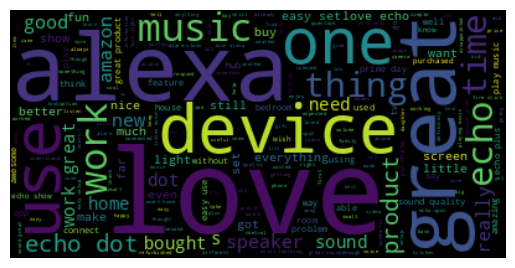

In [23]:
common_words=''
for i in data_v1.verified_reviews:
 i = str(i)
 tokens = i.split()
 common_words += " ".join(tokens)+" "
wordcloud = wordcloud.WordCloud().generate(common_words)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [24]:

# Encoded the target column
lb=LabelEncoder()
data_v1['sentiment'] = lb.fit_transform(data_v1['sentiment'])

<ipython-input-24-3c303bced4a2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_v1['sentiment'] = lb.fit_transform(data_v1['sentiment'])


In [25]:
data_v1.head(10)


,verified_reviews,sentiment
0,love echo!,1
1,loved it!,1
2,"sometimes playing game, answer question correc...",1
3,"lot fun thing. yr old learns dinosaurs, contro...",1
4,music,1
5,received echo gift. needed another bluetooth s...,1
6,"without cellphone, cannot use many features. i...",0
7,think th one i've purchased. i'm working getti...,1
8,look great,1
9,love it! i’ve listened song haven’t heard sinc...,1


In [26]:
tokenizer = Tokenizer(num_words=500, split=' ')
tokenizer.fit_on_texts(data_v1['verified_reviews'].values)
X = tokenizer.texts_to_sequences(data['verified_reviews'].values)
X = pad_sequences(X)
X

array([[  0,   0,   0, ...,   0,   1,   2],
       [  0,   0,   0, ...,   0, 187,   5],
       [  0,   0,   0, ..., 251, 263,  24],
       ...,
       [  0,   0,   0, ..., 120, 146,  30],
       [  0,   0,   0, ..., 120,  54, 278],
       [  0,   0,   0, ...,   0,   0,  17]], dtype=int32)

In [27]:

model = Sequential()
model.add(Embedding(500, 120, input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(176, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 328, 120)          60000     
                                                                 
 spatial_dropout1d (SpatialD  (None, 328, 120)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 176)               209088    
                                                                 
 dense (Dense)               (None, 2)                 354       
                                                                 
Total params: 269,442
Trainable params: 269,442
Non-trainable params: 0
_________________________________________________________________
None


In [28]:
#Splitting the data into training and testing
y=pd.get_dummies(data_v1['sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)


In [29]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


In [31]:
batch_size=32
model.fit(X_train, y_train, epochs = 2, batch_size=batch_size, verbose = 1)

Epoch 1/2
69/69 [==============================] - 126s 2s/step - loss: 0.3814 - accuracy: 0.8698
Epoch 2/2
69/69 [==============================] - 120s 2s/step - loss: 0.2923 - accuracy: 0.8848


In [32]:
model.evaluate(X_test,y_test)

30/30 [==============================] - 6s 197ms/step - loss: 0.2914 - accuracy: 0.8709


[0.29136762022972107, 0.870899498462677]

In [35]:
#Intern at Pranathi
#Student of DataTrained- Saurav
#Date -> 24-05-2023
#Time -> 10:47